#### Team members:
* Ekansh Sharma

In [5]:
### General imports
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [45]:
!conda install scipy -y

Channels:
 - defaults
 - anaconda
Platform: linux-64
Solving environment: done

## Package Plan ##

  environment location: /home/sharma/anaconda3/envs/rl_env

  added / updated specs:
    - scipy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    scipy-1.11.3               |  py311h08b1b3b_0        22.0 MB
    ------------------------------------------------------------
                                           Total:        22.0 MB

The following NEW packages will be INSTALLED:

  libgfortran-ng     pkgs/main/linux-64::libgfortran-ng-11.2.0-h00389a5_1 
  libgfortran5       pkgs/main/linux-64::libgfortran5-11.2.0-h1234567_1 
  scipy              pkgs/main/linux-64::scipy-1.11.3-py311h08b1b3b_0 



                                                                                
Preparing transaction: done
Verifying transaction: done
Executing transaction: done


# Dynamic Motion Primitives for Path Learning

In this assignment, you will write your own simple implementation of dynamic motion primitives for learning three-dimensional paths.

## Discrete DMP Implementation [70 points]

Follow the description of DMPs with a discrete canonical system to write your own implementation that allows you to learn a three-dimensional DMP from a given demonstration and then generate paths based on the learned information.

In [121]:
import numpy as np
from scipy.interpolate import interp1d

class DiscreteDMP(object):
    
    def __init__(self):
        self.tau = 1.05
        self.alpha_z = 25
        self.beta_z = self.alpha_z/4
        self.num_bfs = 10
        self.P = None
        self.g = None
        self.y0 = None
        
    def x(self, t):
        """ Exponential decay function
        
        As x exponentially decays, the modulation by x ensures that f → 0
        """
        alpha_x = self.alpha_z / 4
        return np.exp(-(alpha_x * t / self.tau))
    
    def xi(self, t):
        x_t = self.x(t)
        return (x_t * (self.g - self.y0))
    
    def basis_function(self, t):
        sigma = 0.2
        c_i = 0.5
        h_i = (1 / (2 * (sigma**2)))
        bf = np.exp(-h_i * ((t - c_i)**2))
        return bf
    
    def s(self):
        xi_s = np.zeros((self.P, 1))
        for i in range(self.P):
            xi_s[i][0] = self.xi(i)
        return xi_s
    
    def Gamma_mat(self):
        Gamma_i = np.zeros((self.P, self.P))
        for i in range(self.P):
            bf = self.basis_function(i)
            Gamma_i[i][i] = bf
        return Gamma_i
            
    def learn(self, traj) -> None:
        
        y_demo = traj.reshape(-1, 1)
        
        # Get the length of traj
        self.P = y_demo.shape[0]
        # Get goal and starting point
        self.g = y_demo[-1]
        self.y0 = y_demo[0]
        
        # Calculate y_demo_dot and y_demo_dotdot
        y_demo_dot = np.diff(y_demo, axis=0)
        y_demo_dotdot = np.diff(y_demo_dot, axis=0)
        
        # Find the maximum shape among the arrays
        max_shape = max(y_demo.shape, y_demo_dot.shape, y_demo_dotdot.shape)

        # Pad all arrays to match the maximum shape
        y_demo = np.pad(y_demo, [(0, max_shape[0] - y_demo.shape[0]), (0, max_shape[1] - y_demo.shape[1])], mode='constant', constant_values=0)
        y_demo_dot = np.pad(y_demo_dot, [(0, max_shape[0] - y_demo_dot.shape[0]), (0, max_shape[1] - y_demo_dot.shape[1])], mode='constant', constant_values=0)
        y_demo_dotdot = np.pad(y_demo_dotdot, [(0, max_shape[0] - y_demo_dotdot.shape[0]), (0, max_shape[1] - y_demo_dotdot.shape[1])], mode='constant', constant_values=0)

        print(y_demo.shape, y_demo_dot.shape, y_demo_dotdot.shape)

        # Calculate f_target
        f_target = ((self.tau**2 * y_demo_dotdot) - (self.alpha_z * (self.beta_z * (g - y_demo))) - (self.tau * y_demo_dot))
        
        self.weights = np.empty((self.P, 1))
        for i in range(self.P):
            s = self.s()
            Gamma_i= self.Gamma_mat()
            self.weights[i][0] = (s.T @ Gamma_i @ f_target) / (s.T @ Gamma_i @ s)
        
        return self.weights

    def forcing_term(self, ):
        bf_sum = 0
        weighted_bf_sum = 0
        for i in range(self.num_bfs):
            bf = self.basis_function(i)
            bf_sum += bf
            weight = self.weights[i][0]
            weighted_bf = bf * weight
            weighted_bf_sum += weighted_bf
        
        f = ((weighted_bf_sum/ bf_sum) * (self.x(self.g - self.y0))
        return f
             
    def unroll(self, y0: np.ndarray, g: np.ndarray) -> np.ndarray:
        
        self.y0 = y0
        self.g = g
        for i in range(self.P):
            z_dot = self.alpha * (beta * (self.g - y[i]) - z) + f[i]
            y_dot = z
        
        return np.array(trajectory)


## Implementation Verification [30 points]

Verify that your implementation is working correctly and investigate the factors that affect the reconstruction error.

For the evaluation, generate multiple mathematical curves and use those to represent demonstrations from which you can learn the DMP weights.

The evaluation should consist of two parts:
* Plot your results (the generated and the reconstructed curves, similar to what is shown on lecture slide 16) to qualitatively evaluate the reconstruction.
* Use a similarity metric to evaluate the curve similarity quantitatively (e.g. mean squared error).

In your evaluation, investigate how changing the number of basis functions affects the error.

(100, 1) (100, 1) (100, 1)
[[8.51583947]
 [8.51583947]
 [8.51583947]
 [8.51583947]
 [8.51583947]
 [8.51583947]
 [8.51583947]
 [8.51583947]
 [8.51583947]
 [8.51583947]
 [8.51583947]
 [8.51583947]
 [8.51583947]
 [8.51583947]
 [8.51583947]
 [8.51583947]
 [8.51583947]
 [8.51583947]
 [8.51583947]
 [8.51583947]
 [8.51583947]
 [8.51583947]
 [8.51583947]
 [8.51583947]
 [8.51583947]
 [8.51583947]
 [8.51583947]
 [8.51583947]
 [8.51583947]
 [8.51583947]
 [8.51583947]
 [8.51583947]
 [8.51583947]
 [8.51583947]
 [8.51583947]
 [8.51583947]
 [8.51583947]
 [8.51583947]
 [8.51583947]
 [8.51583947]
 [8.51583947]
 [8.51583947]
 [8.51583947]
 [8.51583947]
 [8.51583947]
 [8.51583947]
 [8.51583947]
 [8.51583947]
 [8.51583947]
 [8.51583947]
 [8.51583947]
 [8.51583947]
 [8.51583947]
 [8.51583947]
 [8.51583947]
 [8.51583947]
 [8.51583947]
 [8.51583947]
 [8.51583947]
 [8.51583947]
 [8.51583947]
 [8.51583947]
 [8.51583947]
 [8.51583947]
 [8.51583947]
 [8.51583947]
 [8.51583947]
 [8.51583947]
 [8.51583947]
 [8.515

/tmp/ipykernel_33401/2013965788.py:36: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  xi_s[i][0] = self.xi(i)
/tmp/ipykernel_33401/2013965788.py:78: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  weights[i][0] = (s.T @ Gamma_i @ f_target) / (s.T @ Gamma_i @ s)
/tmp/ipykernel_33401/2013965788.py:93: RuntimeWarning: invalid value encountered in scalar divide
  f = (np.sum(basis_functions * weights) / np.sum(basis_functions)) * y * (g - y0)


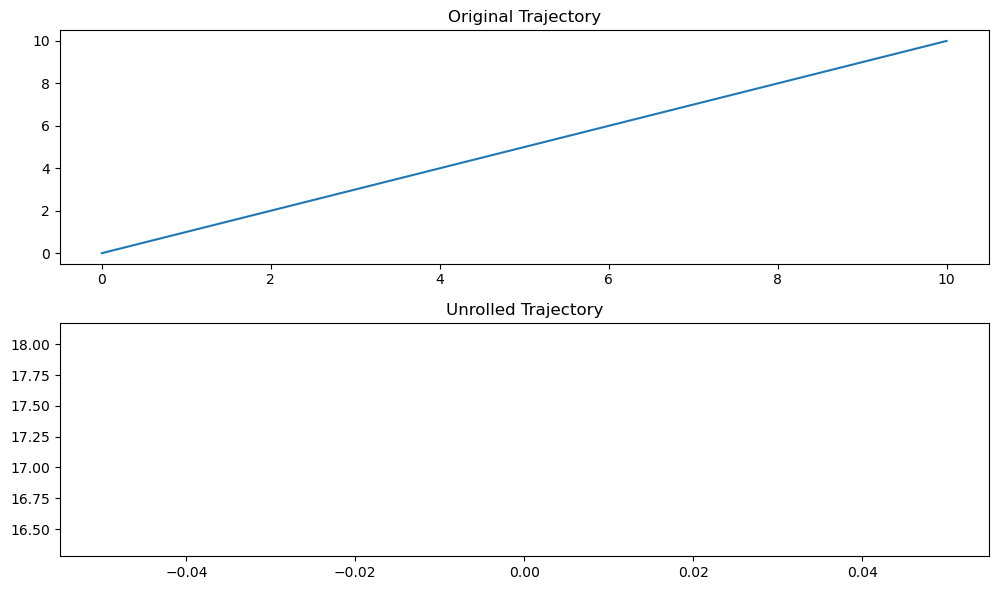

In [122]:
### write code to test your implementation here

"""
We assume that a desired behavior is given by one or multiple de-
sired trajectories in terms of position, velocity, and acceleration triples
(y demo(t), ˙y demo(t), ¨y demo(t)), where t ∈ [1, . . . , P].
"""

import numpy as np

# Time vector
t = np.linspace(0, 10, 100)  # Replace with your time range

# Sample desired trajectories (position, velocity, and acceleration)
traj = t

dmp = DiscreteDMP()
weights = dmp.learn(traj)

# weights = np.full(100, weights[0][0]).reshape(-1, 1)
unroll = dmp.unroll(traj[0], traj[-1], weights)
unroll


# Plot the original trajectory and the unrolled trajectory
plt.figure(figsize=(10, 6))

plt.subplot(2, 1, 1)
plt.plot(t, traj, label="Original Trajectory")
plt.title("Original Trajectory")

plt.subplot(2, 1, 2)
plt.plot(np.linspace(0, 10, len(unroll)), unroll, label="Unrolled Trajectory")
plt.title("Unrolled Trajectory")

plt.tight_layout()
plt.show()


Discuss the results of your evaluation here.

YOUR ANSWER HERE

## (Optional) Rhythmic DMPs

Follow the description of DMPs with a rhythmic canonical system to write your own implementation that allows you to learn and reproduce rhythmic DMPs.

In [67]:
class RhythmicDMP(object):
    def __init__(self):
        # YOUR CODE HERE
        raise NotImplementedError()

    def learn(self) -> None:
        """Learns a rhythmic dynamic motion primitive.
        """
        # YOUR CODE HERE
        raise NotImplementedError()

    def unroll(self, y0: np.ndarray) -> np.ndarray:
        """Generates a rhythmic path that starts at y0, following a learned DMP shape.

        Keyword arguments:
        y0: np.ndarray -- Initial state of the system

        Returns a numpy array representing path waypoints.

        """
        # YOUR CODE HERE
        raise NotImplementedError()

Verify that your implementation is working correctly by experimenting with various rhythmic functions.

In [ ]:
### write code to test your implementation here

# YOUR CODE HERE
raise NotImplementedError()